# The Relation Between Runs and Wins

In [55]:
import sys
sys.path.append('..')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting_utils import plot_regression

sns.set_theme(style='darkgrid', palette='deep')

## Load Data

Teams win by outscoring opponents. Exploring this relationship using MLB data from 2001-2024.

Data source: [Lahman Baseball Database](https://sabr.org/lahman-database/)

In [56]:
teams = pd.read_csv('../data/lahman/Teams.csv')

In [57]:
teams.tail(3)

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
3581,2024,AL,TEX,TEX,W,3,162,81.0,78,84,...,106.0,0.987,Texas Rangers,Globe Life Field,2651553.0,96.0,96.0,TEX,TEX,TEX
3582,2024,AL,TOR,TOR,E,5,162,81.0,74,88,...,125.0,0.984,Toronto Blue Jays,Rogers Centre,2681236.0,103.0,103.0,TOR,TOR,TOR
3583,2024,NL,WAS,WSN,E,4,162,81.0,71,91,...,155.0,0.981,Washington Nationals,Nationals Park,1967302.0,96.0,98.0,WSN,MON,WAS


Filter to recent seasons and extract key variables:
- **R**: Runs scored
- **RA**: Runs allowed
- **W/L**: Wins and losses

In [58]:
my_teams = teams.loc[teams['yearID'] > 2000, ['teamID', 'name', 'yearID', 'lgID', 'G', 'W', 'L', 'R', 'RA']]
my_teams.head()

,teamID,name,yearID,lgID,G,W,L,R,RA
2864,ANA,Anaheim Angels,2001,AL,162,75,87,691.0,730.0
2865,ARI,Arizona Diamondbacks,2001,NL,162,92,70,818.0,677.0
2866,ATL,Atlanta Braves,2001,NL,162,88,74,729.0,643.0
2867,BAL,Baltimore Orioles,2001,AL,162,63,98,687.0,829.0
2868,BOS,Boston Red Sox,2001,AL,161,82,79,772.0,745.0


Calculate **Run Differential (RD)** and **Winning Percentage (Wpct)**:

In [59]:
my_teams['RD'] = my_teams['R'] - my_teams['RA']
my_teams['Wpct'] = my_teams['W'] / (my_teams['W'] + my_teams['L'])
my_teams.head()

,teamID,name,yearID,lgID,G,W,L,R,RA,RD,Wpct
2864,ANA,Anaheim Angels,2001,AL,162,75,87,691.0,730.0,-39.0,0.462963
2865,ARI,Arizona Diamondbacks,2001,NL,162,92,70,818.0,677.0,141.0,0.567901
2866,ATL,Atlanta Braves,2001,NL,162,88,74,729.0,643.0,86.0,0.543210
2867,BAL,Baltimore Orioles,2001,AL,162,63,98,687.0,829.0,-142.0,0.391304
2868,BOS,Boston Red Sox,2001,AL,161,82,79,772.0,745.0,27.0,0.509317


## Linear Regression:

$$Wpct = a + b \times RD + \epsilon$$


Plot relationship between **Run Differential (RD)** and **Winning Percentage (Wpct)** for 2001-2024 seasons

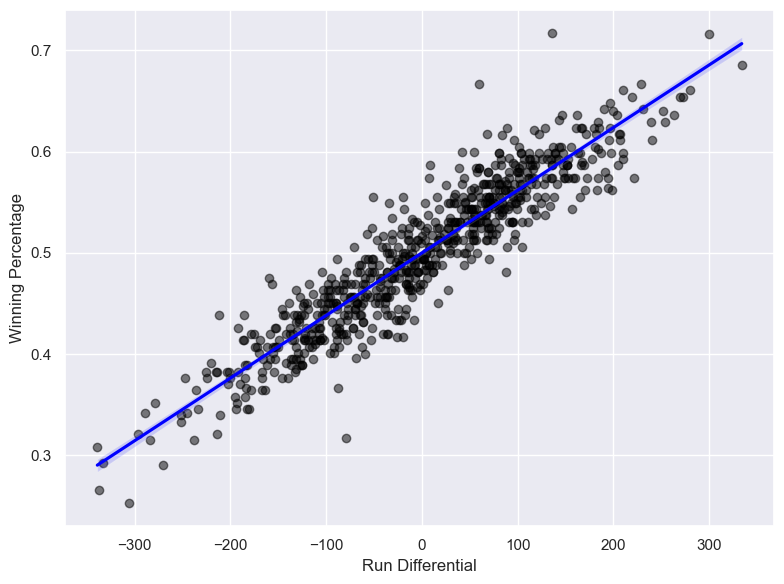

In [60]:
plot_regression(data=my_teams, x='RD', y='Wpct', xlabel='Run Differential', ylabel='Winning Percentage')
plt.show()

In [61]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Fit linear regression model
X = my_teams[['RD']].values
y = my_teams['Wpct'].values

linfit = LinearRegression()
linfit.fit(X, y)

# Display coefficients
intercept = linfit.intercept_
slope = linfit.coef_[0]

print(f"Intercept (a): {intercept:.6f}")
print(f"Slope (b): {slope:.6f}")
print(f"Equation: Wpct = {intercept:.6f} + {slope:.6f} * RD")

Intercept (a): 0.499988
Slope (b): 0.000619
Equation: Wpct = 0.499988 + 0.000619 * RD


Interpretation:
- The **intercept** (≈0.500) represents the expected winning percentage when run differential is 0
- The **slope** (≈0.0006) means each additional run in differential increases winning percentage by about 0.0006
- A 10-run differential increase ≈ 0.006 winning percentage ≈ 1 additional win (out of 162 games)

In [62]:
from sklearn.metrics import root_mean_squared_error

# Calculate predictions and residuals
my_teams['predicted_Wpct'] = linfit.predict(X)
my_teams['residuals'] = my_teams['Wpct'] - my_teams['predicted_Wpct']

# Calculate R-squared
r_squared = linfit.score(X, y)
print(f"R-squared: {r_squared:.4f}")

# Calculate RMSE (Root Mean Square Error)
rmse = root_mean_squared_error(y, my_teams['predicted_Wpct'])
print(f"RMSE: {rmse:.4f}")
print(f"This means predictions are accurate within about {rmse*100:.1f} percentage points")

R-squared: 0.8664
RMSE: 0.0277
This means predictions are accurate within about 2.8 percentage points


In [63]:
# View some examples with predictions and residuals
my_teams[['name', 'yearID', 'W', 'L', 'RD', 'Wpct', 'predicted_Wpct', 'residuals']].sample(10)

,name,yearID,W,L,RD,Wpct,predicted_Wpct,residuals
3237,Los Angeles Dodgers,2013,92,70,67.0,0.567901,0.541439,0.026462
3440,Cincinnati Reds,2020,31,29,0.0,0.516667,0.499988,0.016679
3137,Boston Red Sox,2010,89,73,74.0,0.549383,0.545770,0.003613
3014,Arizona Diamondbacks,2006,76,86,-15.0,0.469136,0.490708,-0.021572
3167,Boston Red Sox,2011,90,72,138.0,0.555556,0.585365,-0.029810
3236,Los Angeles Angels of Anaheim,2013,78,84,-4.0,0.481481,0.497513,-0.016031
2866,Atlanta Braves,2001,88,74,86.0,0.543210,0.553194,-0.009984
2946,Pittsburgh Pirates,2003,75,87,-48.0,0.462963,0.470291,-0.007328
3532,Colorado Rockies,2023,59,103,-236.0,0.364198,0.353980,0.010218
3109,Chicago Cubs,2009,83,78,35.0,0.515528,0.521641,-0.006113


## Residual Plot

Figure 4.2 displays a plot of the residuals against the run differential. We'll highlight the 6 teams with the largest residuals.

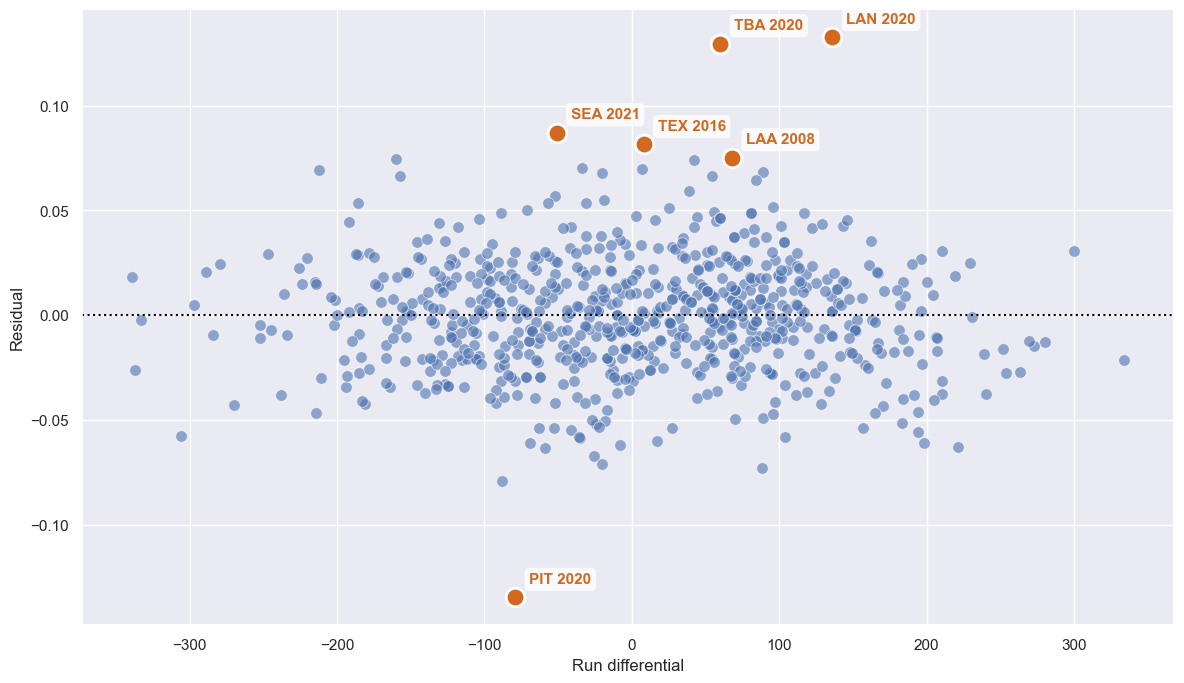

In [68]:
# Residual plot with highlighted teams
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(data=my_teams, x='RD', y='residuals', alpha=0.6, color='#4C72B0', s=70, ax=ax)
ax.axhline(y=0, linestyle=':', color='black', linewidth=1.5)
ax.set_xlabel('Run differential', fontsize=12)
ax.set_ylabel('Residual', fontsize=12)

# Find 5 highest residuals and 1 lowest residual
top_5 = my_teams.nlargest(5, 'residuals')
bottom_1 = my_teams.nsmallest(1, 'residuals')
highlight_teams = pd.concat([top_5, bottom_1])

# Highlight and label these teams
for _, row in highlight_teams.iterrows():
    ax.scatter(row['RD'], row['residuals'], color='#D2691E', s=180, zorder=5, edgecolors='white', linewidth=2)
    ax.annotate(f"{row['teamID']} {int(row['yearID'])}", 
               xy=(row['RD'], row['residuals']),
               xytext=(10, 10), 
               textcoords='offset points',
               color='#D2691E', 
               fontsize=11,
               fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.8))

plt.tight_layout()
plt.show()